# Мастерская данных 1. Моделирование выживаемости стартапов

На основе псевдо-реальных данных о стартапах, функционировавших в период с 1970 по 2018 годы,  необходимо предсказать, какие из них закроются.

## Установка и импорт библиотек

In [1]:
# Установим необходимые сторонние библиотеки
! pip install phik -q
! pip install catboost -q

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

# Импортируем небходимые модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Импортируем сторонние библиотеки
import phik
from catboost import CatBoostClassifier

## Импорт и предобработка данных

In [3]:
train_dataset = pd.read_csv('kaggle_startups_train_28062024.csv')
test_dataset = pd.read_csv('kaggle_startups_test_28062024.csv')

In [4]:
# Взглянем на загруженные данные
display(train_dataset.head())
train_dataset.info()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [5]:
# Взглянем на загруженные данные
display(test_dataset.head())
test_dataset.info()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Столбец name не несет ценной информации, поэтому сразу удалим его из обоих датасетов. 
Кроме того, из тренировочного датасета сразу отделим целевую переменную (в которой отсутсвуют пропуски, что критично важно).

В первую очередь мы видим, что форматы данных не соответствуют необходимым.

Необходимо изменить следующие форматы данных:  
founded_at - datetime  
first_funding_at - datetime  
last_funding_at - datetime  



In [6]:
train_dataset['first_funding_at'] = train_dataset['first_funding_at'].astype('datetime64[ns]')
train_dataset['last_funding_at'] = train_dataset['last_funding_at'].astype('datetime64[ns]')
train_dataset['founded_at'] = train_dataset['founded_at'].astype('datetime64[ns]')
train_dataset['closed_at'] = train_dataset['closed_at'].astype('datetime64[ns]')

test_dataset['first_funding_at'] = test_dataset['first_funding_at'].astype('datetime64[ns]')
test_dataset['last_funding_at'] = test_dataset['last_funding_at'].astype('datetime64[ns]')

Далее рассмотрим пропущенные значения.

In [7]:
train_dataset.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

* 1 пропуск в поле name не является проблемой, поле не будет использовано в модели.
* 47599 пропусков в поле closed_at - полностью совпадает со списком действующих стартапов. Пропуски полностью логичны, это знаит что стартап не закрыт по состоянию на 2018-01-01. Для полноты картины заполним этот признак текущей датой 2018-01-01. В дальнейшем не будем использовать этот столбец в явном виду, только для создания дополнительных признаков. 
* 2465 пропусков в Category list - необходимо заполнять пропуски. Изучим распределение, возможно заполним наиболее часто встречающейся категорией.
* 10069 пропусков в funding_total_usd - необходимо заполнять пропуски. Изучим распределение, возможно, заполним медианным/средним значением.
* Поля country_code, state_code, region, city - для всех записей, в которых пропущено значение страны, пропуещены и другие географические поля.

In [8]:
train_dataset['closed_at'] = train_dataset['closed_at'].fillna(pd.to_datetime('2018-01-01'))

Сами по себе столбцы с данными нам не понадобятся, составим на их основе ряд возможных переменных

In [9]:
train_dataset['lifetime'] = (train_dataset.closed_at-train_dataset.founded_at).dt.days

# Год получения первого раунда фондирования
train_dataset['first_funding_year'] = train_dataset['first_funding_at'].dt.year
test_dataset['first_funding_year'] = test_dataset['first_funding_at'].dt.year


train_dataset = train_dataset.drop(['founded_at','first_funding_at','last_funding_at','closed_at'],axis=1)
test_dataset = test_dataset.drop(['first_funding_at','last_funding_at'],axis=1)

Логично было бы еще создать переменную period_between_fundings, но она была бы линейно выразима через другие 3 переменные (как lifetime - time_to_first_funding - time_from_last_funding). Кроме того, косвенно мы учтем информацию о повторных продолжительных финансированияхз через количество раундов фондирования.

Проверим наличие дубликатов в датасете

In [10]:
print(train_dataset.duplicated().sum()) 
print(test_dataset.duplicated().sum()) 

0
0


Явные дубликаты отсутствуют

Итак, мы выяснили, что в данных:  
(1) отсутствуют явные дубликаты  
(2) изменили форматы нескольких столбцов  
(3) необходимо заполнить множество пропущенных значений переменных

Заполнение пропусков мы проведем далее после предварительного анализа корреляций.

## Предварительный анализ корреляций

Используем библиотеку phik

In [11]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                52515 non-null  object 
 1   category_list       50051 non-null  object 
 2   funding_total_usd   42447 non-null  float64
 3   status              52516 non-null  object 
 4   country_code        47014 non-null  object 
 5   state_code          45753 non-null  object 
 6   region              46157 non-null  object 
 7   city                46157 non-null  object 
 8   funding_rounds      52516 non-null  int64  
 9   lifetime            52516 non-null  int64  
 10  first_funding_year  52516 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 4.4+ MB


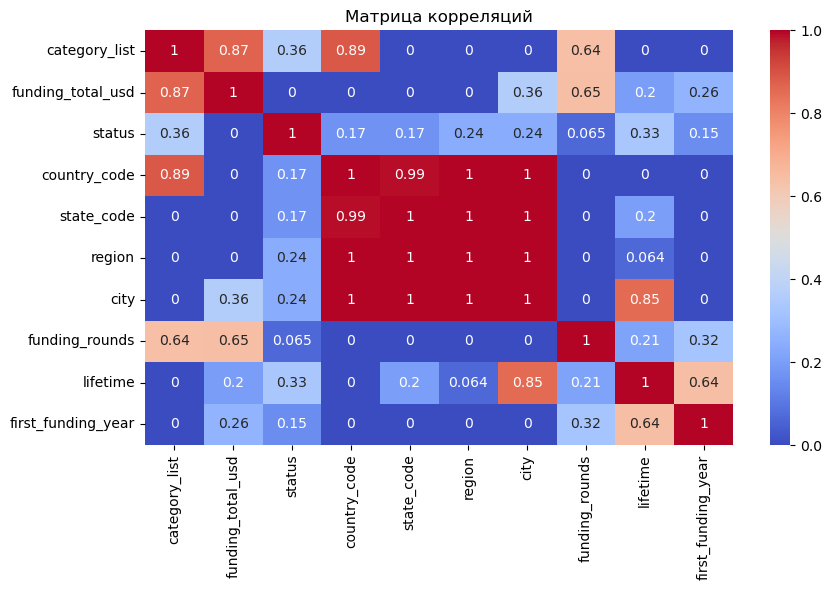

In [12]:
phik_overview = train_dataset.dropna().drop('name',axis=1).sample(1000)

plt.figure(figsize = (9,6))
sns.heatmap(phik_overview.phik_matrix(interval_cols=['funding_total_usd', 'funding_rounds', 'funding_period', 'lifetime']),
            annot = True,cmap='coolwarm')
plt.title('Матрица корреляций')

plt.tight_layout()
plt.show()

В первую очередь важно отметить сильнейшую взаимосвязь между переменными локации. В дальнейшем мы соберем ценную информацию о локации в одно поле и удалим остальные для избежания мультиколлинеарности.
В остальном, большинство переменных имеют слабую корреляцию с целевой (status), самым сильным влиянием обладает переменная lifetime.

## Работа с полем category_list

В первую очередь определимся с логикой заполнения категории стартапов.

In [13]:
# Найдем все уникальные названия категорий стартапов и сколько раз они встречаются

train_dataset['category_list'] = train_dataset['category_list'].str.split('|',expand = False)
train_dataset.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_year
0,Lunchgate,"[Online Reservations, Restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2998,2011
1,EarLens,"[Manufacturing, Medical, Medical Devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,4748,2010
2,Reviva Pharmaceuticals,[Biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,4383,2012
3,Sancilio and Company,[Health Care],22250000.0,operating,NaN,NaN,NaN,NaN,3,5114,2011
4,WireTough Cylinders,[Manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2791,2012


In [14]:
train_dataset['n_categories'] = train_dataset['category_list'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)
train_dataset['n_categories'].max()

40.0

Мы видим, что в датасете встречаются стартапы, у которых задано до 40 категорий. Необходимо выбрать только одну.

Создадим частотный справочник для названий категорий.
В случае, если у стартапа несколько категорий, из них должны выбираться самая частов стерчающая категория.

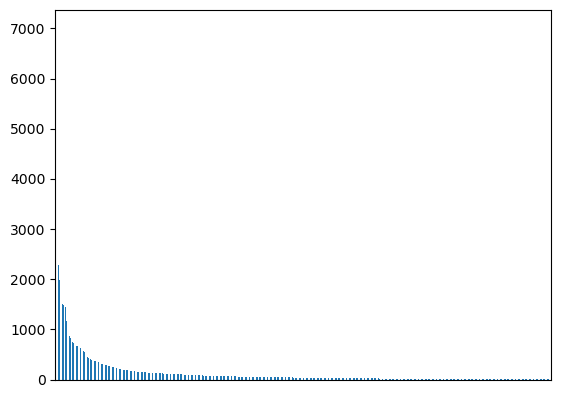

In [15]:
all_categopries_series = train_dataset['category_list'].explode().reset_index(drop=True)

all_categopries_series.value_counts().plot(kind='bar')
plt.xticks([])
plt.show()

Мы видим, что категории стартапов представлены очень неравномерно. Ожидаем, что после нашего упражнения ситуация значительно улучшится и редко встречающиеся категории стартапов заменятся на более распространенные.

In [16]:
# Частотный справочник
category_freq = dict(all_categopries_series.value_counts())

In [17]:
# Функция для выбора элемента с самым большим значением из справочника
def select_max_value(lst, value_dict):
    if not isinstance(lst, list):
        return np.nan
    
    return max(lst, key=lambda x: value_dict.get(x, 0))

train_dataset['category'] = train_dataset['category_list'].apply(select_max_value, value_dict=category_freq)

In [18]:
display(train_dataset.head())

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_year,n_categories,category
0,Lunchgate,"[Online Reservations, Restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2998,2011,2.0,Restaurants
1,EarLens,"[Manufacturing, Medical, Medical Devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,4748,2010,3.0,Manufacturing
2,Reviva Pharmaceuticals,[Biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,4383,2012,1.0,Biotechnology
3,Sancilio and Company,[Health Care],22250000.0,operating,NaN,NaN,NaN,NaN,3,5114,2011,1.0,Health Care
4,WireTough Cylinders,[Manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2791,2012,1.0,Manufacturing


В целом нам удлось преобразовать форматы данных таким образом, чтобы каждому стартапу соответствовала одна категория. Однако мы все еще имеем сликом большое кол-во категорий и все еще не заполнили пропуски.


In [19]:
# Загрузим заранее подготовленный справочник с верхнеуровневой группировкой категорий стартапов
category_dict = pd.read_csv('category_dict.csv').set_index('category')['up_category'].to_dict()

train_dataset['category_subs'] = train_dataset['category'].apply(lambda x: category_dict.get(x, 'Other'))

In [20]:
train_dataset

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_year,n_categories,category,category_subs
0,Lunchgate,"[Online Reservations, Restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2998,2011,2.0,Restaurants,Entertainment
1,EarLens,"[Manufacturing, Medical, Medical Devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,4748,2010,3.0,Manufacturing,Manufacturing
2,Reviva Pharmaceuticals,[Biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,4383,2012,1.0,Biotechnology,Biotechnology
3,Sancilio and Company,[Health Care],22250000.0,operating,NaN,NaN,NaN,NaN,3,5114,2011,1.0,Health Care,Health Care
4,WireTough Cylinders,[Manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2791,2012,1.0,Manufacturing,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,[Entertainment],NaN,operating,CAN,ON,Toronto,Kitchener,1,2192,2014,1.0,Entertainment,Entertainment
52512,Hello Curry,[Hospitality],500000.0,operating,IND,2,Hyderabad,Hyderabad,1,1590,2014,1.0,Hospitality,Services
52513,Taskforce,"[Email, Messaging, Productivity Software]",50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2741,2009,3.0,Messaging,Entertainment
52514,NetScaler,[Security],13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,7336,1998,1.0,Security,Technology


C точки зрения заполнения пропусков, мы можем заполнить пропущенные значения категорией Other

In [21]:
# Удалим промежуточные столбцы
train_dataset = train_dataset.drop(['n_categories','category','category_list'], axis = 1)

In [22]:
train_dataset.head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_year,category_subs
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,2998,2011,Entertainment
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,4748,2010,Manufacturing
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,4383,2012,Biotechnology
3,Sancilio and Company,22250000.0,operating,NaN,NaN,NaN,NaN,3,5114,2011,Health Care
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,Bristol,1,2791,2012,Manufacturing


In [23]:
train_dataset.category_subs.value_counts()

Software         10207
Services          6658
Entertainment     6053
Technology        4466
Mobile            4454
E-Commerce        3765
Biotechnology     3674
Marketing         3633
Other             3546
Health Care       3292
Manufacturing     2768
Name: category_subs, dtype: int64

Проделаем такую же обработку с тестовым датасетом, на оснвое данных тренирочного (частотные таблицы и тд.) т.к. модель косвенно через трансформации не должна ничего знать о тестовой выборке.

In [24]:
test_dataset['category_list'] = test_dataset['category_list'].str.split('|',expand = False)

test_dataset['n_categories'] = test_dataset['category_list'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)
test_dataset['n_categories'].max()

44.0

In [25]:
test_dataset['category'] = test_dataset['category_list'].apply(select_max_value, value_dict=category_freq)
test_dataset['category_subs'] = test_dataset['category'].apply(lambda x: category_dict.get(x, 'Other'))

In [26]:
# Удалим промежуточные столбцы
test_dataset = test_dataset.drop(['n_categories','category','category_list'], axis = 1)

In [27]:
test_dataset.category_subs.value_counts()

Software         2478
Services         1730
Entertainment    1528
Technology       1150
Mobile           1098
E-Commerce        929
Other             902
Marketing         897
Biotechnology     872
Health Care       836
Manufacturing     705
Name: category_subs, dtype: int64

## Работа с полями country_code, state_code, region, city

Как мы выяснили раньше, у всех 4 переменных связанных с локацией крайне сильная корреляция - вероятна проблема мультиколлинеарности.
Для того, чтобы избавиться от нее, удалим часть переменных. По логике кажется, что больше всего информации может нести страна стартапа, оставим только ее, предварительно сгруппировав.

In [28]:
country_freq = dict(train_dataset.country_code.value_counts())
train_dataset.country_code.value_counts().head(15)

USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
FRA      916
DEU      834
ISR      767
ESP      607
NLD      380
AUS      379
SWE      373
RUS      369
SGP      356
BRA      355
Name: country_code, dtype: int64

Видим, что стартапы из США доминируют в датасете, занимая примерно 60%. Помимо укрупнения стран попробуем дополнительно разбить США.

In [29]:
train_dataset[train_dataset['country_code']=='USA'].groupby(['state_code']).size().sort_values().tail()

state_code
FL     1038
TX     1562
MA     2020
NY     3112
CA    10219
dtype: int64

In [30]:
train_dataset[(train_dataset['country_code']=='USA')].groupby(['state_code','city']).size().sort_values().tail(10)

state_code  city         
CA          Mountain View     463
            San Diego         480
MA          Boston            504
IL          Chicago           546
WA          Seattle           592
CA          Los Angeles       603
            Palo Alto         607
TX          Austin            608
NY          New York         2485
CA          San Francisco    2824
dtype: int64

На основе частотного спарвочника стран (подготовлен заранее) сгруппируем страны по их региону/группе стран. Помимо этого, так как на США приходится более половины наблюдений, для США дополнительно выделим крупнейшие штаты, а также крупнейший город.

In [31]:
# Загрузим предподготовленный справочник стран и регионов
country_dict = pd.read_csv('country_dict.csv').set_index('Country')['Country_group'].to_dict()

In [32]:
train_dataset['country_group'] = train_dataset['country_code'].apply(lambda x: country_dict.get(x, 'Other'))


In [33]:
#Дополнительно разделим США
x = train_dataset[train_dataset['country_group']=='USA']
train_dataset.loc[train_dataset['country_group']=='USA','country_group'] = np.where(x['state_code']=='CA','USA-CA',
                                                                                np.where(x['state_code']=='NY','USA-NY',
                                                                                        np.where(x['state_code']=='MA','USA-MA',
                                                                                                np.where(x['state_code']=='TX','USA-TX','USA-other'))))

train_dataset.loc[(train_dataset['country_group']=='USA-CA')&(train_dataset['city']=='San Francisco'),'country_group'] = 'USA-SF'

In [34]:
train_dataset.head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_year,category_subs,country_group
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,2998,2011,Entertainment,Other_Europe
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,4748,2010,Manufacturing,USA-CA
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,4383,2012,Biotechnology,USA-CA
3,Sancilio and Company,22250000.0,operating,NaN,NaN,NaN,NaN,3,5114,2011,Health Care,Other
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,Bristol,1,2791,2012,Manufacturing,USA-other


In [35]:
train_dataset.country_group.value_counts()

USA-other       12789
USA-CA           7395
Non_US_G7        6850
Other            5873
Other_Europe     4510
Asia             3686
USA-NY           3112
USA-SF           2824
USA-MA           2020
USA-TX           1562
LATAM             978
MENA              917
Name: country_group, dtype: int64

In [36]:
train_dataset = train_dataset.drop(['country_code','state_code','region','city'], axis = 1)

Повторим преобразование для тестовой выборки

In [37]:
test_dataset['country_group'] = test_dataset['country_code'].apply(lambda x: country_dict.get(x, 'Other'))

#Дополнительно разделим США
x = test_dataset[test_dataset['country_group']=='USA']
test_dataset.loc[test_dataset['country_group']=='USA','country_group'] = np.where(x['state_code']=='CA','USA-CA',
                                                                                np.where(x['state_code']=='NY','USA-NY',
                                                                                        np.where(x['state_code']=='MA','USA-MA',
                                                                                                np.where(x['state_code']=='TX','USA-TX','USA-other'))))

test_dataset.loc[(test_dataset['country_group']=='USA-CA')&(test_dataset['city']=='San Francisco'),'country_group'] = 'USA-SF'

test_dataset = test_dataset.drop(['country_code','state_code','region','city'], axis = 1)

## Заполнение переменной funding_total_usd

Рассмотрим распределение переменной funding_total_usd

<Axes: >

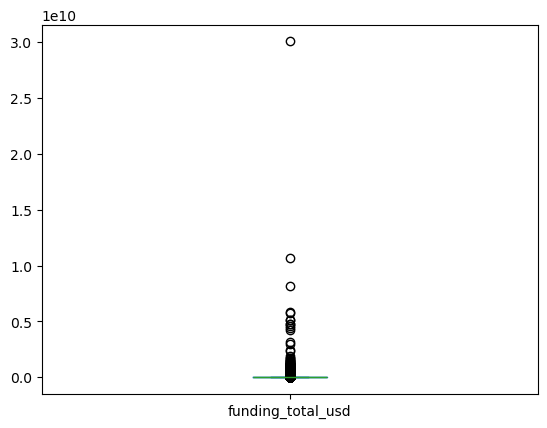

In [38]:
train_dataset['funding_total_usd'].plot.box()

Мы явно видим, что в переменной присутсвтует большое количество выбросов. Для того, чтобы более наглядно 

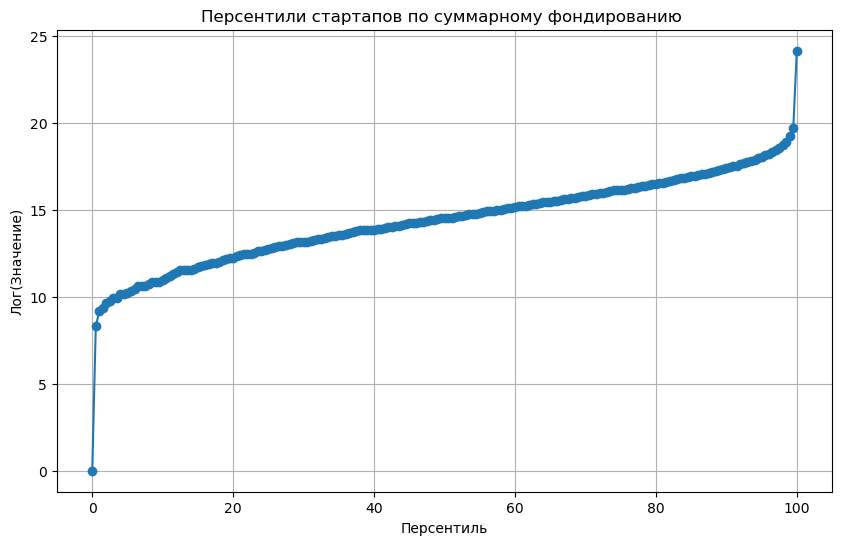

In [39]:
percentiles = np.arange(0, 100.5, 0.5)
values_at_percentiles = np.percentile(train_dataset['funding_total_usd'].dropna(), percentiles)

# Построение графика. Для лучшей репрезентативности посмотрим на логарифмы суммарных инвестиций
plt.figure(figsize=(10, 6))
plt.plot(percentiles, np.log(values_at_percentiles), marker='o', linestyle='-')
plt.xlabel('Персентиль')
plt.ylabel('Лог(Значение)')
plt.title('Персентили стартапов по суммарному фондированию ')
plt.grid(True)
plt.show()

Даже в в логарифмах мы видим огромный выброс на первых и последних 0.5% выборки - обработаем такие наблюдения.

В качестве обработки предлагаем не удалять такие значения, а привести их к значению 0.5 и 99.5 персентиля соответсвтенно - с точки зрения информации для модели и важности признака это все так же остануться стартапы с низким/высоким значением фондирования, однако ошибка на них не должна так критично отразиться на функции потерь.

In [40]:
train_dataset['funding_total_usd'] = train_dataset['funding_total_usd'].clip(upper=np.percentile(train_dataset['funding_total_usd'].dropna(),99.5))
train_dataset['funding_total_usd'] = train_dataset['funding_total_usd'].clip(np.percentile(train_dataset['funding_total_usd'].dropna(),0.5))

Сохраним медианные значения для соответствующего региона и индустрии для того, чтобы в дальнейшем заполнить ими данные из тестовой выборки.

In [41]:
funding_dict = dict(train_dataset.groupby(['category_subs','country_group'])['funding_total_usd'].median())

В обучающем датасете пропущено порядка 20% переменной funding_total_usd. Кажется, что заполнение такого большого количества пропусков может значительно исказить распределение переменной. Попробуем не учитывать пропущенные наблюдения при обучении модели, и без того обучающая выборка имеет достаточно большой размер (более 40000 наблюдений). Убедиться в такой предпосылке можно будет после проверки на валидационном наборе данных.

In [42]:
train_dataset['funding_total_usd_filled'] = train_dataset['funding_total_usd']

train_dataset = train_dataset.dropna(subset='funding_total_usd_filled')

Повторим преобразование для тестовой выборки

In [43]:
test_dataset['funding_total_usd_filled'] = test_dataset['funding_total_usd']

for i in test_dataset[test_dataset.funding_total_usd.isna()].index:
    test_dataset.loc[i,'funding_total_usd_filled'] = funding_dict.get((test_dataset.loc[i,'category_subs'],
                                                                       test_dataset.loc[i,'country_group']))

## Анализ входных признаков модели

После всех преобразований построим еще раз матрицу корреляций

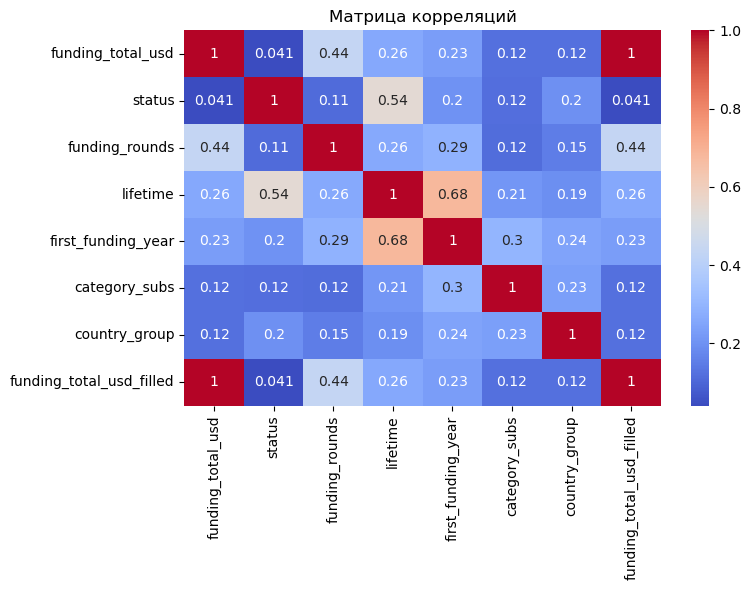

In [44]:
phik= train_dataset.drop('name',axis=1)#.sample(3000)

plt.figure(figsize = (8,6))
sns.heatmap(phik.phik_matrix(interval_cols=['funding_total_usd','funding_total_usd_filled', 'funding_rounds', 'funding_period',
                                            'lifetime','funding_total_usd_filled']),
            annot = True,cmap='coolwarm')
plt.title('Матрица корреляций')

plt.tight_layout()
plt.show()

Мы видим, что кроме переменной lifetime ну у одной переменной нет заметной корреляции с целевой переменной.  
Причина может быть в том, как мы обрабатывали данные и заполняли пропуски, а также в наличии нелинейных связей.
Тем не менее, корреляции с переменными, отвечающими за категорию стартапа, а также за его страну, выросли.
Попробуем создать новые переменные и проверить корреляции еще раз.

Посмотрим на распределение срока жизни стартапа с разбиением по целевой переменной.

1357.0


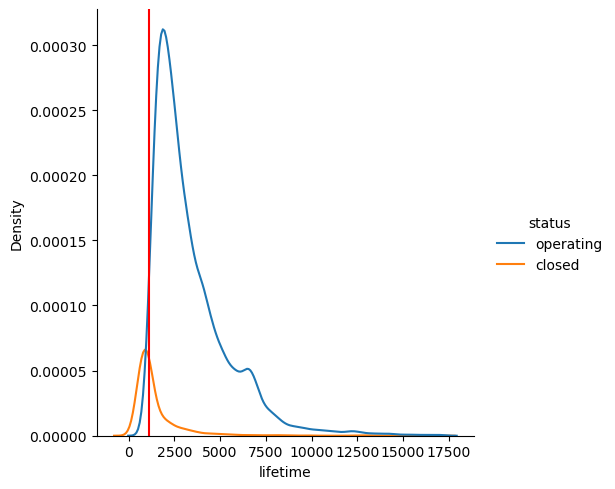

In [45]:
sns.displot(data = train_dataset, x  = 'lifetime', hue = 'status', kind = 'kde')

print(np.percentile(train_dataset[train_dataset['status']=='closed']['lifetime'],70))
plt.axvline(1100, color = 'red')

мы видим, что большинство закрывшихся стартапов сконцентрированы в области низких значений lifetime (условно меньше 3 лет) - выделим их в отдельную категорию.

In [46]:
train_dataset['lifetime_cat'] = np.where(train_dataset['lifetime'] < 1100,'<3 Y','>3Y+')
                                         
train_dataset['lifetime_cat'].value_counts()

>3Y+    39618
<3 Y     2829
Name: lifetime_cat, dtype: int64

Рассмотрим переменную funding_rounds.

In [47]:
train_dataset['funding_rounds'].value_counts()

1     24300
2      9110
3      4329
4      2153
5      1160
6       613
7       339
8       174
9       108
10       61
11       46
12       22
13        9
16        6
15        5
14        5
17        3
18        3
19        1
Name: funding_rounds, dtype: int64

Видим, что группы крайне неравномерны. Стартапов, получивших финансирование больше 5 раз в целом не очень много, объединим их в одну категорию.

In [48]:
# Попробуем учесть нелинейность в количестве раундов фондирования - разобъем на группы
train_dataset['funding_rounds_cat'] = np.where(train_dataset['funding_rounds']==1,'1',
                                              np.where(train_dataset['funding_rounds'] ==2,'2',
                                                      np.where(train_dataset['funding_rounds']==3,'3',
                                                              np.where(train_dataset['funding_rounds']==4,'4',
                                                                      np.where(train_dataset['funding_rounds']==5,'5', '5+')))))
train_dataset['funding_rounds_cat'].value_counts()

1     24300
2      9110
3      4329
4      2153
5+     1395
5      1160
Name: funding_rounds_cat, dtype: int64

Повторно построим матрицу корреляций.

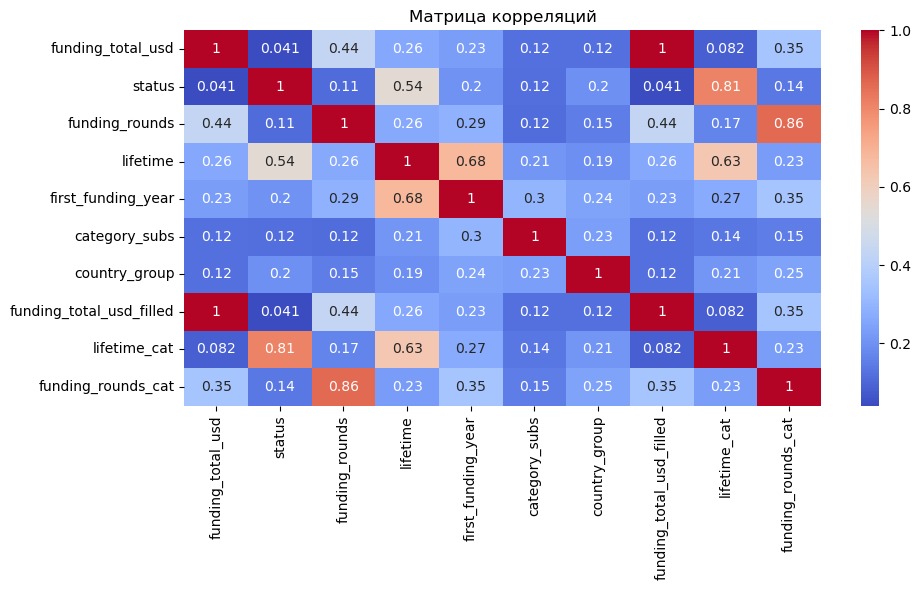

In [49]:
phik= train_dataset.drop('name',axis=1)
plt.figure(figsize = (10,6))
sns.heatmap(phik.phik_matrix(interval_cols=['funding_total_usd','funding_total_usd_log', 'funding_rounds',
                                            'funding_period', 'lifetime','fund_per_round',
                                           'log_lifetime','funding_total_usd_filled_log','funding_total_usd_filled']),
            annot = True,cmap='coolwarm')
plt.title('Матрица корреляций')

plt.tight_layout()
plt.show()

Мы видим, что у преобразованных переменных относительно неплохая корреляция с таргетов (funding_rounds_cat > funding_rounds). Кроме того, разделенная на категории ligetime имеет крайне сильную корреляцию в таргетом. При средней корреляции с исходной lifetime мы можем оставить обе переменные.

Повторим преобразования для тестовой выборки.

In [50]:
test_dataset['lifetime_cat'] = np.where(test_dataset['lifetime'] < 1100,'<3 Y','>3Y+')

test_dataset['funding_rounds_cat'] = np.where(test_dataset['funding_rounds']==1,'1',
                                              np.where(test_dataset['funding_rounds'] ==2,'2',
                                                      np.where(test_dataset['funding_rounds']==3,'3',
                                                              np.where(test_dataset['funding_rounds']==4,'4',
                                                                      np.where(test_dataset['funding_rounds']==5,'5', '5+')))))

## Подготовка пайплайна для поиска оптимальной модели классификации

На основе предварительного анализ, следующие переменные попадут в итоговый датасет для поиска оптимальной модели:  
'category_subs', 'country_group', 'funding_total_usd_filled','funding_rounds_cat', 'lifetime','first_funding_year','lifetime_cat'


In [51]:
train_dataset = train_dataset[['name', 'status',
       'category_subs', 'country_group', 'funding_total_usd_filled',
       'funding_rounds_cat', 'lifetime','first_funding_year','lifetime_cat']]

In [52]:
# Определим группы переменных

ohe_columns = ['country_group','category_subs','lifetime_cat']
ord_columns = ['funding_rounds_cat']
num_columns = ['funding_total_usd_filled','lifetime','first_funding_year']

In [53]:
ohe_pipe = Pipeline(
    [
        (
            'ohe_enc', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ordinal_pipe = Pipeline(
    [
        ('simpleImputer_ordinal_before', 
         SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
        ('ordinal_enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                                  unknown_value=-1,
                                  categories = [['1','2','3','4','5','5+']])),
        ('simpleImputer_ordinal_after', 
         SimpleImputer(missing_values=np.nan,strategy='most_frequent'))
    ]
)

In [54]:
data_preprocessor = ColumnTransformer(
    transformers= [
       ('ohe', ohe_pipe, ohe_columns),
       ('ord', ordinal_pipe, ord_columns),
       ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [55]:
# Создадим каркас итогового пайплайна для подбора гиперпараметров и выбора модели. Для старта инициализируем модель логистической регрессии.

RANDOM_STATE = 142

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [56]:
# Создадим словарь со всеми комбинациями гиперпараметров

param_distributions = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver = 'saga',penalty = 'elasticnet', max_iter = 100)],
        'models__class_weight':[None,'balanced'],
        'models__l1_ratio':[0,0.1,0.25,0.4,0.5,0.6,0.75,0.9,1],      
        'models__C':np.linspace(0.1,10,25),
        'preprocessor__num': [StandardScaler()]  
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__class_weight':[None,'balanced'],
        'models__max_depth': range(2, 8),
        'models__min_samples_split':range(2,4),
        'models__min_samples_leaf':range(1,3),
        'preprocessor__num': [StandardScaler(),'passthrough']  
    },
    {
        'models': [CatBoostClassifier(verbose=0,random_state=RANDOM_STATE)]
        'models__n_estimators': range(2, 30),
        'models__depth': range(1, 8),
        'models__learning_rate':[0.05,0.1,0.2],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    }
] 

In [57]:
%%time

RANDOM_STATE = 142

X_train = train_dataset.drop(['name','status'],axis=1)
y_train = train_dataset['status']

# Закодируем целевую переменную
lbl_encoder = LabelEncoder()
y_train = lbl_encoder.fit_transform(y_train) # 1 = operating

# Зададим отдельынй вид кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    scoring = 'f1' ,
    cv = cv, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

CPU times: user 2min 19s, sys: 43.9 s, total: 3min 3s
Wall time: 1h 7min 45s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=142, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe_enc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['country_group',
                                                                          'category_subs',
                                                                          'lifetime_cat']),
                                                                        ('ord',
                                                                         Pipeline(ste...
                          'models__min_samples_leaf': range(1, 3),
                          'models__min_samples_split': range(2, 4),
                          'preprocessor__num': [StandardScaler(),
                                                'passthrough']},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7f8a25719150>],
                          'models__depth': range(1, 8),
                          'models__learning_rate': [0.05, 0.1, 0.2],
                          'models__n_estimators': range(2, 30),
                          'preprocessor__num': [StandardScaler(),
                                                'passthrough']}],
             scoring='f1')

In [58]:
grid_search.best_score_

0.9870488144036823

In [59]:
grid_search.best_params_

{'models': <catboost.core.CatBoostClassifier at 0x7f8a25719150>,
 'models__depth': 7,
 'models__learning_rate': 0.2,
 'models__n_estimators': 29,
 'preprocessor__num': StandardScaler()}

Построим предсказания об успешности стартапов на основе обученной модели.

In [60]:
output = pd.DataFrame(test_dataset['name'])

In [61]:
test_dataset = test_dataset[['category_subs', 'country_group', 'funding_total_usd_filled','lifetime_cat',
       'funding_rounds_cat', 'lifetime','first_funding_year']]

In [62]:
test_dataset.head()

,category_subs,country_group,funding_total_usd_filled,lifetime_cat,funding_rounds_cat,lifetime,first_funding_year
0,Technology,Other,2819200.0,>3Y+,1,3501,2009
1,Services,USA-other,1985100.0,>3Y+,1,2717,2010
2,Services,Other_Europe,428257.0,>3Y+,2,1295,2014
3,Software,USA-CA,34700000.0,>3Y+,4,4748,2005
4,Software,Non_US_G7,4530000.0,>3Y+,1,6209,2007


In [63]:
prob_operating = grid_search.predict_proba(test_dataset)[:,1]

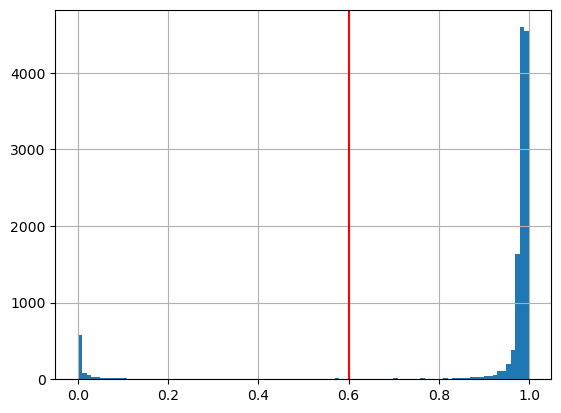

In [64]:
pd.Series(prob_operating).hist(bins = 100)

plt.axvline(0.6, color = 'red')

На основе экспериментов с валидационной выборкой (test на kaggle) был подобран оптимальный порог вероятности классификации = 0.6.

In [65]:
threshold = 0.6
print(len(prob_operating[prob_operating>=threshold]))

12018


In [66]:
threshold = 0.6
print(len(prob_operating[prob_operating>=threshold]))
output['oper_proba'] = prob_operating
output['status'] = np.where(output['oper_proba']>=threshold, 'operating','closed')
output.head()

12018


,name,oper_proba,status
0,Crystalsol,0.980799,operating
1,JBI Fish & Wings,0.971148,operating
2,COINPLUS,0.959408,operating
3,Imagine Communications,0.974937,operating
4,DNA13,0.980178,operating


In [67]:
output[['name','status']].to_csv('output_fin.csv',index = False)

## Анализ важности признаков модели

Построим график важности признаков в оптимальной модели.

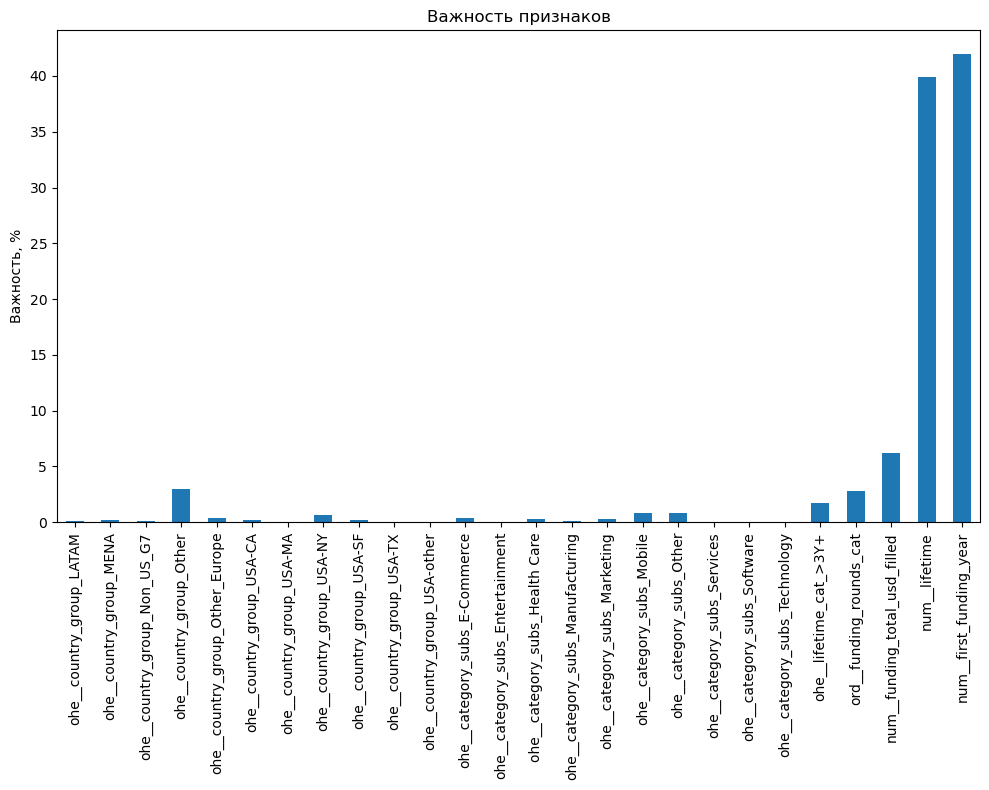

In [68]:
cat_iris_imp = pd.Series(grid_search.best_estimator_['models'].get_feature_importance(),
                        grid_search.best_estimator_['preprocessor'].get_feature_names_out())
fig, ax = plt.subplots(figsize=(10,8))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

наиболее значимыми оказались first_funding_year, ifetime. На втором плане переменные финансовые funding_total_usd_filled и funding_rounds_cat. 
Хотя в целом переменные Country_group и Category_subs, закодированные OneHotEncoder, не оказывают очень большого влияние, для некоторых категорий влияние ощутимо.

## Отчет об исследовании

В данном проекте мы использовлаи тренировочный датасет, состоящий из ~52 тысяч наблюдений, для построения модели машинного обучения.
Эта модель должна определять, закроется ли стартап или нет.

В первую очередь мы провели предвариетльную обработку и подготовку данных, в рамках которой:
1) Были приведены в порядок форматы данных
2) Было проверено наличие явных дубликатов
3) Был проведен первичный корреляционный анализ, который продемонстрировал, что все 4 переменные, описывающие локацию, крайне сильно взаимосвязаны, в связи с чем в дальнейшем мы оставили только одну переменную для избежания мультиколлинеарности.
4) Была проведена обработка и удаление неявных дубликатов в признаке, описывающим отрасль стартапа. На входе мы получили нестандартизованные списки разрозненных категорий. Для каждого стартапа была отобрана категория из перечня, которая встречается чаще всего. После проведения этой операции у нас все еще оставалось более 500 уникальных категорий. На этом этапе категории были укрупнены до 10 широких категорий на основе их логической схожести по смыслу. Пропущенные значения были заполнены категорией other.
6) Была проведена обработка переменной country code. В переменной насчитывалось порядка 200 уникальных значений. Мы укрупнили данные категории - перешли от стран к группам стран. Помимо этого, так как на США приходится более 60% датасета, для этой страны мы доволнительно выделили самый крупный город и самый крупный штат, чтобы итоговые группы получились сопоставими по размеру. Пропущенные значения были заполнены категорией other.
7) Переменная funding_total_usd пимерно на 20% состояла из пропусков. Так как эта доля слишком велика, мы исключили эти наблюдения, чтобы не создавать дополнительного шума в модели засчет приблизительного заполнения пропусков. Для заполнения пропусков в тестовой выборке мы использовали медианные значения funding_total_usd для соответствущих country_group и category из обучающей выборки.
8) Переменная funding_rounds была преобразована в категориальную с категориями от 1 до 5, а также категорией 5+
9) Переменная лайфтайм была разделена на категории до 3 лет и больше 3 лет, так как исследовательский анализ показал, что большинство закрывшихся стартапов сокнцентрированно в области до 3х лет.

В результате phik корреляция переменных с целевой status значительно выросла. На вход в модель были переданы следующие признаки (c указанием кодировки):
* Country_group - ctaegorical -  ohe encoded
* Category_subs - ctaegorical -  ohe encoded
* lifitime_cat - ctaegorical -  ohe encoded
* funding_rounds_cat - ctaegorical -  ordinal encoded
* funding_total_usd_filled - numeric - StandardScaler
* ifetime - numeric - StandardScaler
* first_funding_year - numeric - StandardScaler

Для поиска оптимальной модели использовался grid search по широкому набору моделей и их гипрепараметров. Из моделей были включены LogisticRegression, DecisionTreeClassifier и CatBoostClassifier.

Для борьбы с оверфитингом мы использовали stratified кросс-валидацию (с сохранением постоянных пропорций таргет переменной в выборке).
Для борьбы с несбалансированностью классов в целевой переменной при подборе гиперпарамтеров моделей анализировался также параметр class_weight = 'balanced'.

В результате, оптимальной оказалась модель CatBoostClassifier на основе 29 деревьев с глубиной  7, лернинг рейт 0.2.
Модель демонстрирует высокое значение метрики f1-score 0.987 по итогу кросс-валидации.
C точки зрения важности признаков, наиболее значимыми оказались first_funding_year, ifetime. На втором плане переменные финансовые funding_total_usd_filled и funding_rounds_cat. Остальные переменные оказывают слабое влияние, периодически для некоторых стран/категорий наблюдается повышенная важность, но в целом они не так важны как указанные 4 переменные.


При проверке на 50% валидационной выборки значение метрики также оказалось на высоком уровне - 0.865.
